In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import scipy.signal as signal
import math

In [2]:
!wget https://raw.githubusercontent.com/newtonis/tps_imagenes/master/TP6%20-%20image-restoration/pic/pru2old.bmp 
!wget https://raw.githubusercontent.com/newtonis/tps_imagenes/master/TP6%20-%20image-restoration/pic/barraxx.bmp
!wget https://raw.githubusercontent.com/newtonis/tps_imagenes/master/TP6%20-%20image-restoration/pic/lenna.png

--2020-10-08 04:20:36--  https://raw.githubusercontent.com/newtonis/tps_imagenes/master/TP6%20-%20image-restoration/pic/pru2old.bmp
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 251080 (245K) [image/bmp]
Saving to: ‘pru2old.bmp.14’

pru2old.bmp.14      100%[===================>] 245.20K  --.-KB/s    in 0.05s   

2020-10-08 04:20:36 (4.51 MB/s) - ‘pru2old.bmp.14’ saved [251080/251080]

--2020-10-08 04:20:36--  https://raw.githubusercontent.com/newtonis/tps_imagenes/master/TP6%20-%20image-restoration/pic/barraxx.bmp
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting res

# Blind Deconvolution

Dada la foto de una placa en la que se observa un efecto borroso se le aplicó el algoritmo de Richardson Lucy de image blind deconvolution, en donde se estimo una psf de todos unos, normalizada, de tamaño 13. La funcion implementada, esta basada en la funcion de deconvolucion de skiimage, en donde recibe la imagen, le psf estimada y el número de iteraciones como parámetro de regularización. Se observa en los resultados que el algoritmo permitió corregir en cierto este efecto indeseado borroso.

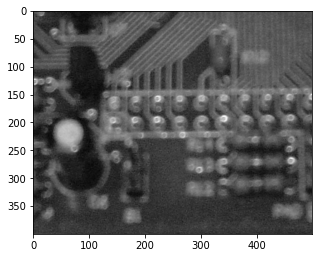

In [3]:
original_image = cv2.imread('barraxx.bmp', cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(5, 5))
plt.imshow(original_image, cmap='gray', vmin=0, vmax=255)

In [4]:
def richardson_lucy(image, psf, iterations=50, clip=True, filter_epsilon=None):
    """https://github.com/scikit-image/scikit-image/blob/master/skimage/restoration/deconvolution.py#L329-L385"""

    float_type = np.promote_types(image.dtype, np.float32)
    image = image.astype(float_type, copy=False)
    psf = psf.astype(float_type, copy=False)
    im_deconv = np.full(image.shape, 0.5, dtype=float_type)
    psf_mirror = np.flip(psf)

    for _ in range(iterations):
        conv = signal.convolve(im_deconv, psf, mode='same')
        if filter_epsilon:
            relative_blur = np.where(conv < filter_epsilon, 0, image / conv)
        else:
            relative_blur = image / conv
        im_deconv *= signal.convolve(relative_blur, psf_mirror, mode='same')

    if clip:
        im_deconv[im_deconv > 1] = 1
        im_deconv[im_deconv < -1] = -1

    return im_deconv

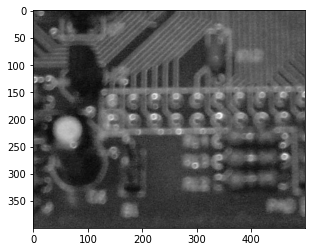

In [5]:
plt.imshow(original_image, cmap='gray', vmin=0, vmax=255)

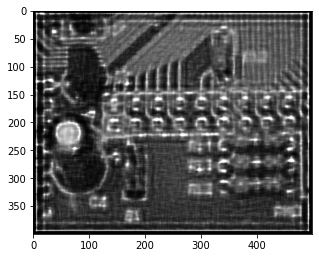

In [6]:
BLIND_DECONV_PSD_KERNEL_SIZE = (13, 13)
kernel = np.full(BLIND_DECONV_PSD_KERNEL_SIZE, 1/BLIND_DECONV_PSD_KERNEL_SIZE[0])

image_deconv = richardson_lucy(original_image.astype(np.float64)/255.0, kernel, iterations=30)

plt.figure(figsize=(5, 5))
plt.imshow(image_deconv, cmap='gray')

# Regularizacion

En esta sección se buscó aplicar el algoritmo de regulación estocastica a una imagen previamente sumergida en ruido y borrosa. Para esta experimentación se utilizó la imagen de Lenna en donde luego comparamos la mejora dado el algoritmo bajo el MSE.

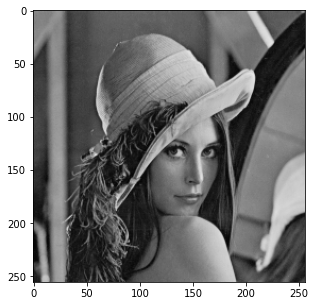

In [7]:
lenna = cv2.imread('lenna.png', cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(5, 5))
plt.imshow(lenna, cmap='gray', vmin=0, vmax=255)

In [8]:
def stochastic_regularization(img, degraded_img, psf, noise):
  PSF_F = np.fft.fft2(np.fft.ifftshift(psf))

  Y = np.fft.fft2(degraded_img)

  noise_power = np.absolute(np.fft.fft2(np.corrcoef(noise)))
  img_power = np.absolute(np.fft.fft2(np.corrcoef(img)))

  restored_img = np.absolute(
      np.fft.ifft2(
          (img_power * np.conj(PSF_F))* Y\
            / (img_power * PSF_F * np.conj(PSF_F) + noise_power))
  )

  return restored_img

In [9]:
def kernel_to_psf(img, kernel):
    """Recieves image and kernel and returns the psf with 0 padding and image size"""

    img_height, img_width = img.shape
    kernel_height, kernel_width = kernel.shape
    pad_height = int((img_height - kernel_height) / 2)
    pad_width = int((img_width - kernel_width) / 2)

    psf = np.pad(kernel, ((pad_height, pad_height), (pad_width, pad_width)), 'constant')

    return psf

In [10]:
def make_1s_kernel(size, norm=True):
    """Makes a 1 matrix kernel with the size required"""
    
    kernel = np.ones((size, size)).astype(np.float64)
    if norm:
        kernel /= size**2
    return kernel

In [11]:
def blurr_image_in_freq_domain(img, psf):
    """ Recieves PSF, not kernel"""

    PSF_F = np.fft.fft2(np.fft.ifftshift(psf))
    IMG_F = np.fft.fft2(img)
    return np.absolute(np.fft.ifft2((PSF_F * IMG_F))).astype(np.float64)

In [12]:
def add_gaussian_noise(img, SNR=10):
    """Adds gaussian noise to the image"""
    row, col = img.shape
    std =  img.std()
    sigma_noise=np.sqrt((std**2) * 10**(-SNR / 10))
    noise = np.random.normal(0, sigma_noise, (row, col))
    noise = noise.reshape(row, col)
    return img + noise, noise

In [13]:
def mse(original_hat, original):
    error = original_hat - original;
    return np.mean(np.square(error))

def nmse(original, procesada):
    var_erro = (np.std(original - procesada))**2
    var_orig = (np.std(original))**2
    norm_mse = 100 * (var_erro / var_orig)
    return norm_mse 

In [14]:
BLURR_KERNEL_SIZE = 10

kernel = make_1s_kernel(BLURR_KERNEL_SIZE)

psf = kernel_to_psf(lenna, kernel)

blurr_img = blurr_image_in_freq_domain(lenna, psf)

blurr_img_with_noise, noise = add_gaussian_noise(blurr_img)

restored_image = stochastic_regularization(lenna, blurr_img_with_noise, psf, noise)

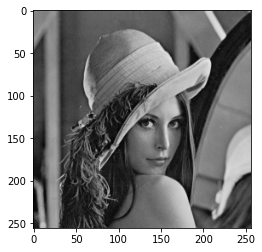

In [15]:
plt.imshow(lenna, cmap='gray', vmin=0, vmax=255)

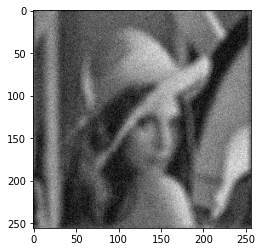

In [16]:
plt.imshow(blurr_img_with_noise, cmap='gray', vmin=0, vmax=255)

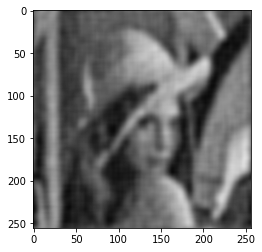

In [17]:
plt.imshow(restored_image, cmap='gray', vmin=0, vmax=255)

In [18]:
DMSE = mse(blurr_img_with_noise, lenna)
print("DMSE = ", DMSE)

RMSE = mse(restored_image, lenna)
print("RMSE = ", RMSE)

DMSE =  640.3785096226742
RMSE =  434.0621489012772
